In [8]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/Drive')

Mounted at /content/Drive


In [2]:
# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score, f1_score, matthews_corrcoef, classification_report, make_scorer
from sklearn.linear_model import LogisticRegression, Lasso
import matplotlib.pyplot as plt
from xlwt import Workbook
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import os
from pandas_profiling import ProfileReport

In [3]:
import warnings
warnings.filterwarnings('ignore')
# !pip freeze
# ! pip install scikit-learn==0.24.2 # Downgrading the scikit learn library to obtain same results of previous experiments and Convergence

In [9]:
# Current working directory and other paths
cwd = os.getcwd()
print(cwd)
!cd Drive/
path = cwd + "/Drive/My Drive/magistrale/BioinformaticsProject/data/"
results_path = cwd + "/Drive/My Drive/magistrale/BioinformaticsProject/results/"

# Count per Million matrix
cpm_dataset = pd.read_csv(path+"CPM.csv",index_col=0) #read the main CPM dataset(67k × 719)
cpm_dataset = cpm_dataset.transpose() # (719 × 67k)
# Training and Testing datasets
training_ds =  pd.read_excel(path+"train.test.xlsx", sheet_name="train")
testing_ds = pd.read_excel(path+"train.test.xlsx", sheet_name="test")

# Feature space datesets
base_feature_space =path+"FEATURE_SPACES(RAW +CPM).xlsx"
# List of feature space name 
feature_space_files =["FEATURE_SPACE1(PAM)", "FEATURE_SPACE2","FEATURE_SPACE3(LIMMA)","FEATURE_SPACE4(LIMMA)", "FEATURE_SPACE7(pamsimilarity)","FEATURE_SPACE8(limmasimilarity)"]

/content


In [10]:
def extract_and_reduce_by_columns(path, sheet_name, name, nofeats_ds, preproc_strategy: str= "none"): 
  """
     Function to extract dataset and a specific group of its columns.

     path: the path where to get the data values (isoforms)
     sheet_name: the excel sheet were to get the columns to select for the data (isoforms)
     nofeats_ds: the dataset without the additional columns
     name: 'trainingset' or 'testingset' for the excel 
     preproc_strategy: which preprocessing strategy to apply to the ds

  """
  full_df = pd.read_excel(path, sheet_name=sheet_name) # path of subdatset 
  full_list= full_df['isoform'].values.tolist()  #exatrct the list of isoforms names as list
  if preproc_strategy == 'loge':
    # https://stackoverflow.com/questions/49538185/purpose-of-numpy-log1p
    log_cpm_dataset = np.log1p(cpm_dataset)
    data = log_cpm_dataset[np.intersect1d(log_cpm_dataset.columns, full_list)]
  elif preproc_strategy == 'log2':
    log_cpm_dataset = np.log2(cpm_dataset + 1) # constant added to avoid reaching zero
    data = log_cpm_dataset[np.intersect1d(log_cpm_dataset.columns, full_list)]
  elif preproc_strategy == 'normperrow':
    # normalize per rows
    data = cpm_dataset[np.intersect1d(cpm_dataset.columns, full_list)]
    data = data.div(data.sum(axis=1), axis=0) # ----> preprocessing scaling step to try, not working
  elif preproc_strategy == 'none':
    data = cpm_dataset[np.intersect1d(cpm_dataset.columns, full_list)]  # find the mutual isoform between main datset and subdatset 
  
  data.reset_index(inplace=True)
  data.rename(columns={ data.columns[0]: "sample_id" }, inplace = True)

  x = nofeats_ds['sample_id'].values.tolist()
  data1= data.loc[data['sample_id'].isin(x)]
  result = pd.merge(data1, nofeats_ds, on='sample_id')
  result
  result.rename(columns={'sample_id.1':'subtype'}, inplace=True )
 
  # result.to_csv(name +".csv", index=False) # save as csv file 
  return result

##Distribution of numerical variables

We now explore the distribution of numerical varibles. We will applu the log2fun

In [11]:
from scipy.stats import skew
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [12]:
cpm_dataset.head()

transcript_id,uc001aab.3,uc001aac.3,uc001aae.3,uc001aah.3,uc001aai.1,uc001aak.2,uc001aal.1,uc001aau.2,uc001aav.3,uc001abe.3,...,uc011nbk.1,uc011nbl.1,uc011nbm.1,uc011nbn.1,uc011nbo.1,uc011nbs.1,uc011nbt.1,uc011nbu.1,uc011nbv.1,uc011nbw.1
TCGA-3C-AAAU,5.195055,0.672913,17.421007,0.000000,54.438856,0.019111,0.0,18.714277,14.426631,1.187965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-3C-AALI,6.797312,0.532043,5.240079,6.452648,37.002506,0.000000,0.0,14.392687,10.248490,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-3C-AALJ,3.198963,2.653702,7.971825,0.000000,47.088828,0.000000,0.0,9.915566,5.127111,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-3C-AALK,5.064226,1.973238,11.828148,0.840518,17.992285,0.000000,0.0,4.443527,6.578962,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-4H-AAAK,3.614929,0.253288,3.782757,0.140887,18.229886,0.000000,0.0,0.000000,7.705960,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# take the numerical features
numeric_feats =cpm_dataset.dtypes.index

# compute the skewness but only for non missing variables (we already imputed them but just in case ...)
skewed_feats = cpm_dataset.iloc[:, :100].apply(lambda x: skew(x.dropna()))

skewness = pd.DataFrame({"Variable":skewed_feats.index, "Skewness":skewed_feats.values})
# select the variables with a skewness above a certain threshold

print(skewed_feats)

transcript_id
uc001aab.3    3.949883
uc001aac.3    5.614743
uc001aae.3    5.119285
uc001aah.3    2.467070
uc001aai.1    1.765445
                ...   
uc001afm.2    0.575368
uc001afn.1    1.357804
uc001afo.3    2.027228
uc001afp.2    2.734682
uc001afq.2    5.937767
Length: 100, dtype: float64


In [14]:
print(skewness)

      Variable  Skewness
0   uc001aab.3  3.949883
1   uc001aac.3  5.614743
2   uc001aae.3  5.119285
3   uc001aah.3  2.467070
4   uc001aai.1  1.765445
..         ...       ...
95  uc001afm.2  0.575368
96  uc001afn.1  1.357804
97  uc001afo.3  2.027228
98  uc001afp.2  2.734682
99  uc001afq.2  5.937767

[100 rows x 2 columns]


In [15]:
skewness = skewness.sort_values('Skewness', ascending=[0])
print(skewness['Skewness'])

72    12.546813
56    12.524039
6     12.476302
37    12.070054
50     8.814489
        ...    
68     1.438204
47     1.416008
96     1.357804
92     1.155626
95     0.575368
Name: Skewness, Length: 100, dtype: float64


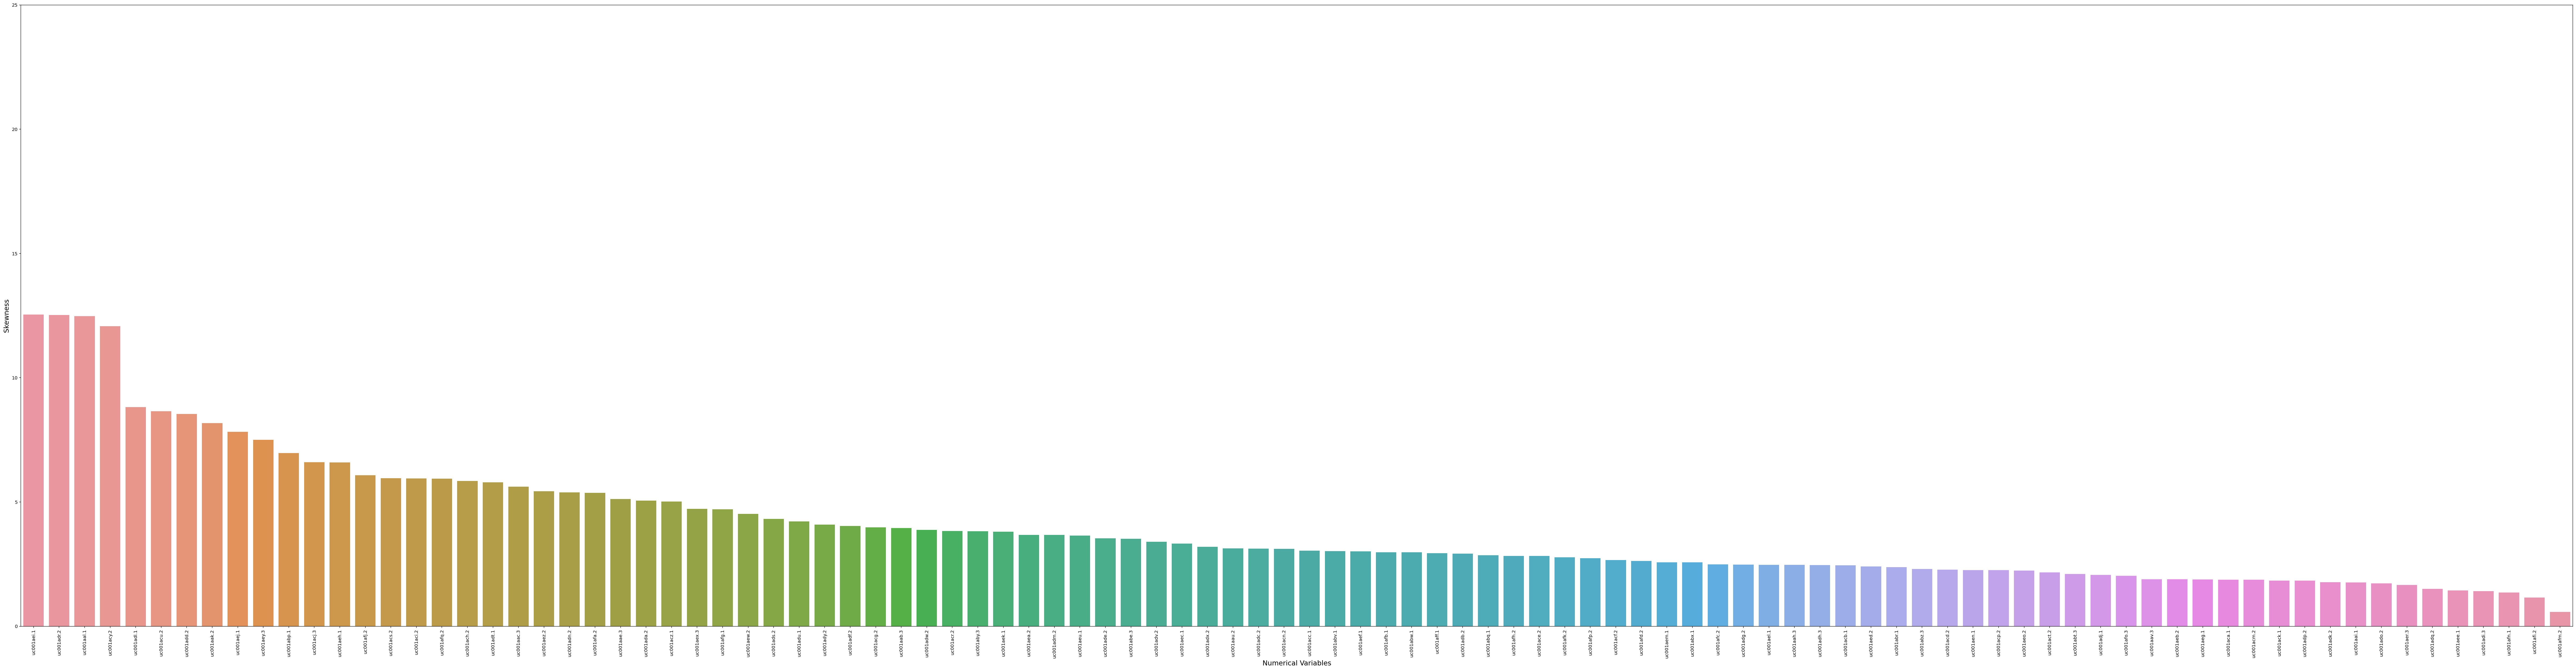

In [16]:
f, ax = plt.subplots(figsize=(100,25))
plt.xticks(rotation='90')
sns.barplot(x=skewness['Variable'], y=skewness['Skewness'])
plt.ylim(0,25)
plt.xlabel('Numerical Variables', fontsize=15)
plt.ylabel('Skewness', fontsize=15)
plt.title('', fontsize=15)

plt.show()



Let's apply the logarithmic transformation to all the variables with a skewness above a certain threshold (0.75). Then, replot the skewness of attributes. Note that to have a fair comparison the two plots should have the same scale.

In [17]:
skewed_feats = skewed_feats[skewed_feats > 0.75]
cpm_dataset[skewed_feats.index] = np.log1p(cpm_dataset[skewed_feats.index])

Text(0.5, 1.0, '')

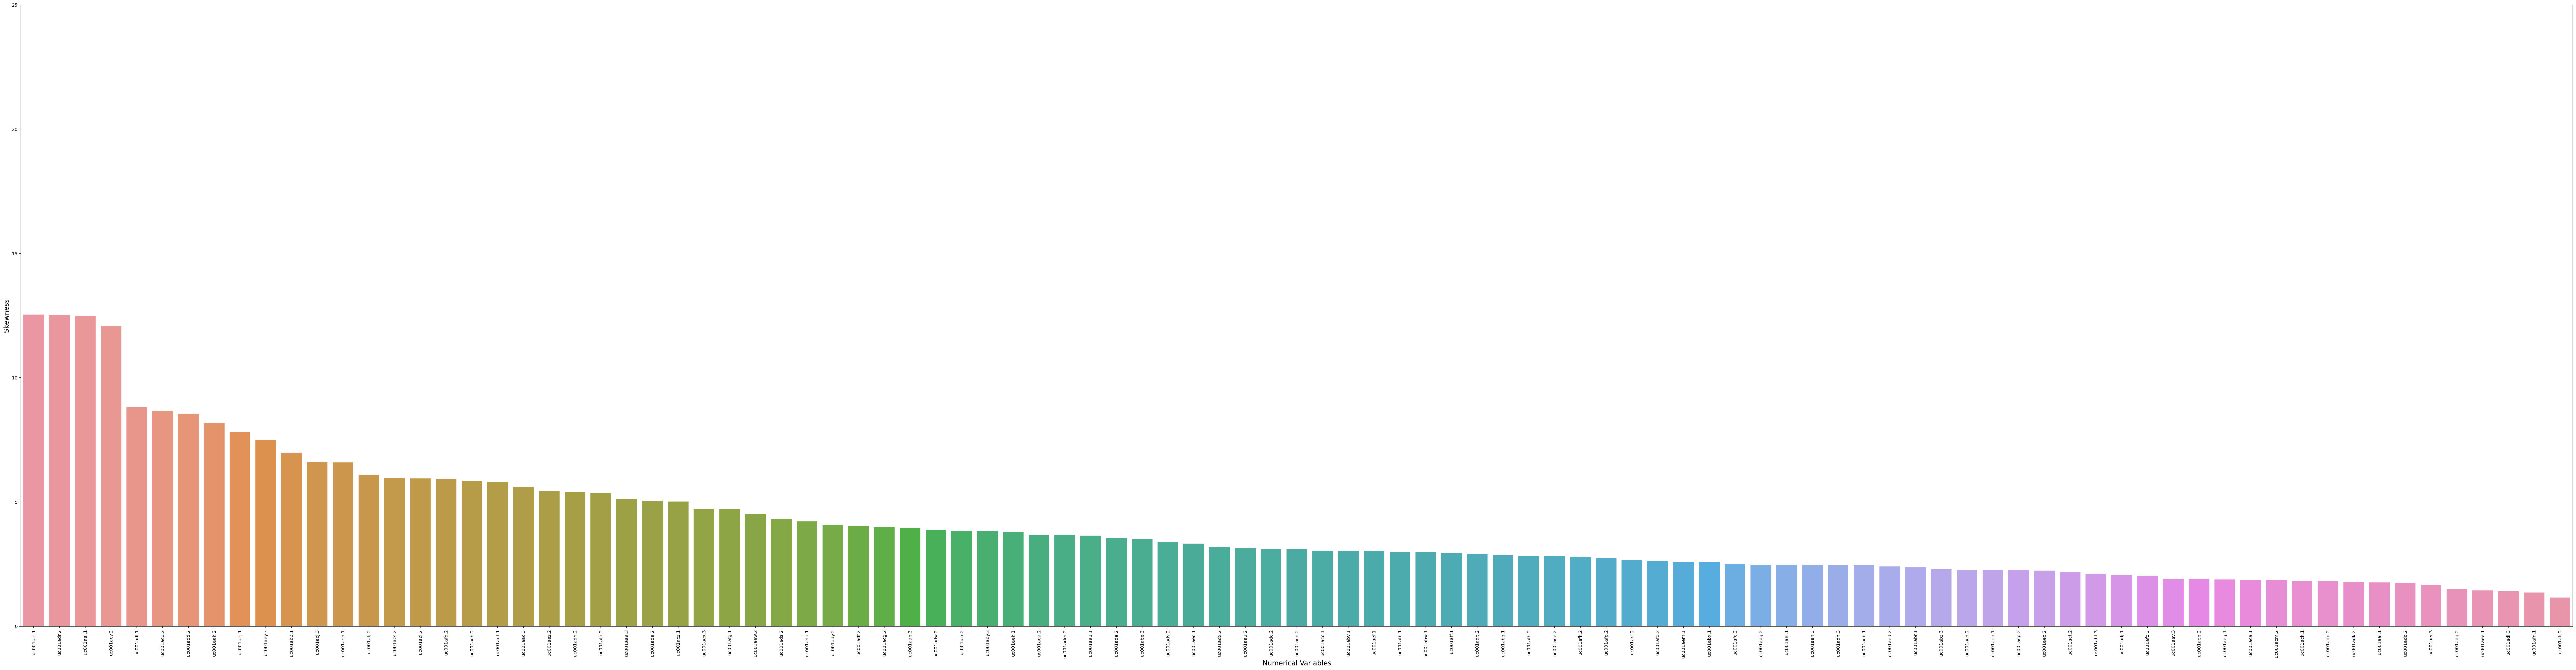

In [18]:
# compute the skewness but only for non missing variables (we already imputed them but just in case ...)
skewness_new = pd.DataFrame({"Variable":skewed_feats.index, "Skewness":skewed_feats.values})
# select the variables with a skewness above a certain threshold

skewness_new = skewness_new.sort_values('Skewness', ascending=[0])

f, ax = plt.subplots(figsize=(100,25))
plt.xticks(rotation='90')
sns.barplot(x=skewness_new['Variable'], y=skewness_new['Skewness'])
plt.ylim(0,25)
plt.xlabel('Numerical Variables', fontsize=15)
plt.ylabel('Skewness', fontsize=15)
plt.title('', fontsize=15)

In [19]:
print(cpm_dataset)

transcript_id  uc001aab.3  uc001aac.3  uc001aae.3  uc001aah.3  uc001aai.1  \
TCGA-3C-AAAU     1.823751    0.514566    2.913492    0.000000    4.015281   
TCGA-3C-AALI     2.053779    0.426602    1.830993    2.008569    3.637652   
TCGA-3C-AALJ     1.434838    1.295741    2.194089    0.000000    3.873050   
TCGA-3C-AALK     1.802407    1.089651    2.551642    0.610047    2.944033   
TCGA-4H-AAAK     1.529296    0.225770    1.565017    0.131806    2.956466   
...                   ...         ...         ...         ...         ...   
TCGA-C8-A3M7     0.394422    0.000000    0.000000    1.700249    3.051080   
TCGA-C8-A3M8     1.272539    0.273125    0.041731    0.000000    3.647624   
TCGA-C8-A8HP     1.324581    0.000000    0.000000    0.359220    3.444745   
TCGA-C8-A8HQ     0.736270    0.893055    0.000000    1.662956    3.101139   
TCGA-C8-A8HR     0.821223    0.276449    0.000000    0.000000    3.498283   

transcript_id  uc001aak.2  uc001aal.1  uc001aau.2  uc001aav.3  uc001abe.3  

**NO PREPROCESSING:** DATASETS WITH FS PAM50 and LIMMA50


In [34]:
# List of feature space name 
feature_space_files =["FEATURE_SPACE6(MAIN)", "FEATURE_SPACE1(PAM)", "FEATURE_SPACE2(PAM)","FEATURE_SPACE1(LIMMA)","FEATURE_SPACE2(LIMMA)", "FEATURE_SPACE7(pamsimilarity)","FEATURE_SPACE8(limmasimilarity)"]

In [35]:
# Training Data import:
train = extract_and_reduce_by_columns(base_feature_space, "FEATURE_SPACE7(pamsimilarity)", 'trainingset', training_ds, 'none') 
X_train_pam = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_pam =train.subtype
print("X_train size:", X_train_pam.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(base_feature_space, "FEATURE_SPACE7(pamsimilarity)",'testingset', testing_ds,'none' ) 
X_test_pam = test.drop(["sample_id","subtype"], axis = 1)
Y_test_pam = test.subtype
print("X_test size:", X_test_pam.shape)

X_train size: (550, 131)
X_test size: (137, 131)


In [36]:
print(X_train_pam.describe())

       uc001cix.2  uc001ciy.2  uc001cmg.3   uc001ehz.2  uc001eib.2  \
count  550.000000  550.000000  550.000000   550.000000  550.000000   
mean    40.408772    4.283931   23.951193    87.395602    0.414667   
std     45.014878    4.635825   22.140506   259.518210    1.250225   
min      1.314143    0.000000    0.000000     0.000000    0.000000   
25%     12.623505    1.419944    9.018923    20.304825    0.071127   
50%     24.727756    2.877836   17.319513    41.153053    0.178128   
75%     49.138632    5.359911   33.132701    89.217146    0.446732   
max    386.657840   46.912066  150.100004  5622.010706   26.436802   

        uc001eic.2  uc001gcq.1  uc001gcr.1  uc001gxx.3  uc001hkm.2  ...  \
count   550.000000  550.000000  550.000000  550.000000  550.000000  ...   
mean      8.096468   11.154435    7.648704   25.412759  136.939897  ...   
std      49.087039   11.158464    8.608324   20.456094  110.622174  ...   
min       0.000000    0.000000    0.000000    1.479666    8.685904  .

In [37]:
# Training Data import:
train = extract_and_reduce_by_columns(base_feature_space, "FEATURE_SPACE8(limmasimilarity)", 'trainingset', training_ds, 'none' ) 
X_train_limma = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_limma =train.subtype
print("X_train size:", X_train_limma.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(base_feature_space, "FEATURE_SPACE8(limmasimilarity)",'testingset', testing_ds, 'none') 
X_test_limma = test.drop(["sample_id","subtype"], axis = 1)
Y_test_limma = test.subtype
print("X_test size:", X_test_limma.shape)

X_train size: (550, 557)
X_test size: (137, 557)


In [38]:
print(X_train_limma.describe())

       uc001aya.1   uc001baf.2  uc001bbd.2  uc001bcr.2  uc001blk.2  \
count  550.000000   550.000000  550.000000  550.000000  550.000000   
mean    17.400357    70.115925   36.458375    0.294295    1.895897   
std     13.863240   121.369945   39.024627    1.328933    2.051967   
min      1.510936     0.000000    4.691971    0.000000    0.000000   
25%      9.014842     8.866997   18.245236    0.000000    0.668038   
50%     13.705259    23.499368   26.013408    0.023850    1.147730   
75%     20.977268    65.973544   40.112144    0.147559    2.436347   
max    131.822014  1005.963722  458.434209   18.364369   17.521710   

       uc001bta.2  uc001cbr.2  uc001cbs.2  uc001cgh.1  uc001chu.2  ...  \
count  550.000000  550.000000  550.000000  550.000000  550.000000  ...   
mean    35.498233    4.442344   22.249384    0.538047    0.547266  ...   
std     40.991021    7.328446   19.581424    1.335701    1.542232  ...   
min      0.000000    0.000000    0.000000    0.000000    0.000000  ...   

**LOGE PREPROCESSING:** DATASET WITH FS PAM50 and LIMMA50




In [39]:
# Training Data import:
train = extract_and_reduce_by_columns(base_feature_space, "FEATURE_SPACE7(pamsimilarity)", 'trainingset', training_ds, 'loge') 
X_train_pam_loge = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_pam_loge=train.subtype
print("X_train size:", X_train_pam_loge.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(base_feature_space, "FEATURE_SPACE7(pamsimilarity)",'testingset', testing_ds,'loge' ) 
X_test_pam_loge = test.drop(["sample_id","subtype"], axis = 1)
Y_test_pam_loge = test.subtype
print("X_test size:", X_test_pam_loge.shape)

X_train size: (550, 131)
X_test size: (137, 131)


In [40]:
print(X_train_pam_loge.describe())

       uc001cix.2  uc001ciy.2  uc001cmg.3  uc001ehz.2  uc001eib.2  uc001eic.2  \
count  550.000000  550.000000  550.000000  550.000000  550.000000  550.000000   
mean     3.288380    1.397662    2.796363    3.767311    0.267218    1.303798   
std      0.927805    0.709950    1.037041    1.132981    0.314857    1.011931   
min      0.839040    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      2.611796    0.883744    2.304474    3.058934    0.068712    0.548450   
50%      3.247568    1.355277    2.907966    3.741298    0.163927    1.128995   
75%      3.914787    1.850011    3.530256    4.502219    0.369307    1.837256   
max      5.960123    3.869367    5.017942    8.634623    3.311885    6.993781   

       uc001gcq.1  uc001gcr.1  uc001gxx.3  uc001hkm.2  ...  uc011kaz.1  \
count  550.000000  550.000000  550.000000  550.000000  ...  550.000000   
mean     2.145614    1.819352    3.020116    4.632826  ...    1.113239   
std      0.867942    0.815822    0.729215    0.8

In [41]:
# Training Data import:
train = extract_and_reduce_by_columns(base_feature_space, "FEATURE_SPACE8(limmasimilarity)", 'trainingset', training_ds, 'loge' ) 
X_train_limma_loge = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_limma_loge =train.subtype
print("X_train size:", X_train_limma_loge.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(base_feature_space, "FEATURE_SPACE8(limmasimilarity)",'testingset', testing_ds, 'loge') 
X_test_limma_loge = test.drop(["sample_id","subtype"], axis = 1)
Y_test_limma_loge = test.subtype
print("X_test size:", X_test_limma_loge.shape)

X_train size: (550, 557)
X_test size: (137, 557)


In [42]:
print(X_train_limma_loge.describe())

       uc001aya.1  uc001baf.2  uc001bbd.2  uc001bcr.2  uc001blk.2  uc001bta.2  \
count  550.000000  550.000000  550.000000  550.000000  550.000000  550.000000   
mean     2.717022    3.275191    3.369821    0.150153    0.901868    3.178833   
std      0.606406    1.431695    0.651227    0.336226    0.525148    0.936876   
min      0.920656    0.000000    1.739057    0.000000    0.000000    0.000000   
25%      2.304067    2.289173    2.957264    0.000000    0.511648    2.501943   
50%      2.688205    3.198647    3.296331    0.023570    0.764410    3.256605   
75%      3.090009    4.204297    3.716298    0.137637    1.234408    3.846229   
max      4.889010    6.914695    6.129996    2.963435    2.918944    6.238642   

       uc001cbr.2  uc001cbs.2  uc001cgh.1  uc001chu.2  ...  uc011ltb.1  \
count  550.000000  550.000000  550.000000  550.000000  ...  550.000000   
mean     1.121925    2.844844    0.278103    0.249021  ...    2.708137   
std      1.017628    0.795469    0.455513    0.4

**LOG2 PREPROCESSING:** DATASET WITH FS PAM50 and LIMMA50

In [43]:
# Training Data import:
train = extract_and_reduce_by_columns(base_feature_space, "FEATURE_SPACE7(pamsimilarity)", 'trainingset', training_ds, 'log2') 
X_train_pam_log2 = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_pam_log2 =train.subtype
print("X_train size:", X_train_pam_log2.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(base_feature_space, "FEATURE_SPACE7(pamsimilarity)",'testingset', testing_ds,'log2' ) 
X_test_pam_log2 = test.drop(["sample_id","subtype"], axis = 1)
Y_test_pam_log2 = test.subtype
print("X_test size:", X_test_pam_log2.shape)

X_train size: (550, 131)
X_test size: (137, 131)


In [44]:
print(X_train_pam_log2.describe())

       uc001cix.2  uc001ciy.2  uc001cmg.3  uc001ehz.2  uc001eib.2  uc001eic.2  \
count  550.000000  550.000000  550.000000  550.000000  550.000000  550.000000   
mean     4.744130    2.016400    4.034300    5.435081    0.385514    1.880983   
std      1.338539    1.024241    1.496134    1.634547    0.454243    1.459908   
min      1.210478    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      3.768025    1.274973    3.324653    4.413108    0.099130    0.791246   
50%      4.685250    1.955251    4.195308    5.397552    0.236497    1.628795   
75%      5.647843    2.669002    5.093083    6.495330    0.532798    2.650601   
max      8.598640    5.582317    7.239360   12.457127    4.778040   10.089894   

       uc001gcq.1  uc001gcr.1  uc001gxx.3  uc001hkm.2  ...  uc011kaz.1  \
count  550.000000  550.000000  550.000000  550.000000  ...  550.000000   
mean     3.095467    2.624771    4.357107    6.683755  ...    1.606065   
std      1.252176    1.176982    1.052036    1.1

In [45]:
# Training Data import:
train = extract_and_reduce_by_columns(base_feature_space, "FEATURE_SPACE8(limmasimilarity)", 'trainingset', training_ds, 'log2' ) 
X_train_limma_log2 = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_limma_log2 =train.subtype
print("X_train size:", X_train_limma_log2.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(base_feature_space, "FEATURE_SPACE8(limmasimilarity)",'testingset', testing_ds, 'log2') 
X_test_limma_log2 = test.drop(["sample_id","subtype"], axis = 1)
Y_test_limma_log2 = test.subtype
print("X_test size:", X_test_limma_log2.shape)

X_train size: (550, 557)
X_test size: (137, 557)


In [46]:
print(X_train_limma_log2.describe())

       uc001aya.1  uc001baf.2  uc001bbd.2  uc001bcr.2  uc001blk.2  uc001bta.2  \
count  550.000000  550.000000  550.000000  550.000000  550.000000  550.000000   
mean     3.919834    4.725101    4.861624    0.216626    1.301120    4.586086   
std      0.874859    2.065500    0.939521    0.485071    0.757629    1.351626   
min      1.328225    0.000000    2.508928    0.000000    0.000000    0.000000   
25%      3.324066    3.302578    4.266429    0.000000    0.738152    3.609540   
50%      3.878260    4.614672    4.755600    0.034005    1.102811    4.698288   
75%      4.457940    6.065519    5.361485    0.198569    1.780875    5.548935   
max      7.053350    9.975796    8.843714    4.275333    4.211145    9.000458   

       uc001cbr.2  uc001cbs.2  uc001cgh.1  uc001chu.2  ...  uc011ltb.1  \
count  550.000000  550.000000  550.000000  550.000000  ...  550.000000   
mean     1.618596    4.104242    0.401217    0.359261  ...    3.907016   
std      1.468127    1.147619    0.657166    0.7

**NORM BY ROW PREPROCESSING:** DATASET WITH FS PAM50 and LIMMA50

In [47]:
# Training Data import:
train = extract_and_reduce_by_columns(base_feature_space, "FEATURE_SPACE7(pamsimilarity)", 'trainingset', training_ds, 'normperrow') 
X_train_pam = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_pam =train.subtype
print("X_train size:", X_train_pam.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(base_feature_space, "FEATURE_SPACE7(pamsimilarity)",'testingset', testing_ds,'normperrow' ) 
X_test_pam = test.drop(["sample_id","subtype"], axis = 1)
Y_test_pam = test.subtype
print("X_test size:", X_test_pam.shape)

X_train size: (550, 131)
X_test size: (137, 131)


In [48]:
print(X_train_pam.describe())

       uc001cix.2  uc001ciy.2  uc001cmg.3  uc001ehz.2  uc001eib.2  uc001eic.2  \
count  550.000000  550.000000  550.000000  550.000000  550.000000  550.000000   
mean     0.006802    0.000708    0.003904    0.013392    0.000063    0.001230   
std      0.008072    0.000816    0.003973    0.025149    0.000125    0.004765   
min      0.000200    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.001841    0.000208    0.001292    0.003049    0.000010    0.000103   
50%      0.003721    0.000434    0.002540    0.006529    0.000027    0.000317   
75%      0.008394    0.000886    0.005285    0.013841    0.000068    0.000830   
max      0.053069    0.006474    0.024400    0.421657    0.001983    0.081664   

       uc001gcq.1  uc001gcr.1  uc001gxx.3  uc001hkm.2  ...  uc011kaz.1  \
count  550.000000  550.000000  550.000000  550.000000  ...  550.000000   
mean     0.001802    0.001269    0.004111    0.022059  ...    0.000913   
std      0.002008    0.001652    0.003712    0.0

In [49]:
# Training Data import:
train = extract_and_reduce_by_columns(base_feature_space, "FEATURE_SPACE8(limmasimilarity)", 'trainingset', training_ds, 'normperrow' ) 
X_train_limma = train.drop(["sample_id","subtype"],  axis = 1)
Y_train_limma =train.subtype
print("X_train size:", X_train_limma.shape)

# Testing Data import:
test = extract_and_reduce_by_columns(base_feature_space, "FEATURE_SPACE8(limmasimilarity)",'testingset', testing_ds, 'normperrow') 
X_test_limma = test.drop(["sample_id","subtype"], axis = 1)
Y_test_limma = test.subtype
print("X_test size:", X_test_limma.shape)

X_train size: (550, 557)
X_test size: (137, 557)


In [50]:
print(X_train_limma.describe())

       uc001aya.1  uc001baf.2  uc001bbd.2  uc001bcr.2  uc001blk.2  uc001bta.2  \
count  550.000000  550.000000  550.000000  550.000000  550.000000  550.000000   
mean     0.001121    0.004899    0.002259    0.000021    0.000108    0.002284   
std      0.001433    0.009751    0.003055    0.000114    0.000127    0.003342   
min      0.000043    0.000000    0.000156    0.000000    0.000000    0.000000   
25%      0.000410    0.000401    0.000850    0.000000    0.000033    0.000552   
50%      0.000687    0.001231    0.001345    0.000001    0.000062    0.001257   
75%      0.001258    0.003797    0.002416    0.000009    0.000135    0.002769   
max      0.020163    0.072391    0.034253    0.001686    0.001018    0.043423   

         uc001cbr.2  uc001cbs.2  uc001cgh.1  uc001chu.2  ...  uc011ltb.1  \
count  5.500000e+02  550.000000  550.000000  550.000000  ...  550.000000   
mean   2.967731e-04    0.001415    0.000039    0.000028  ...    0.001855   
std    5.859138e-04    0.001689    0.00010